✅ Combined dataset shape: (43020, 687)
✅ Columns: ['hour_ts', 'start_station_name', 'start_station_id', 'ride_count', 'hour', 'hour_sin', 'hour_cos', 'day_of_week', 'is_holiday_or_weekend', 'month', 'is_peak_hour', 'day_of_year', 'time_of_day', 'ride_count_roll3', 'target_ride_count', 'ride_count_lag_1', 'ride_count_lag_2', 'ride_count_lag_3', 'ride_count_lag_4', 'ride_count_lag_5', 'ride_count_lag_6', 'ride_count_lag_7', 'ride_count_lag_8', 'ride_count_lag_9', 'ride_count_lag_10', 'ride_count_lag_11', 'ride_count_lag_12', 'ride_count_lag_13', 'ride_count_lag_14', 'ride_count_lag_15', 'ride_count_lag_16', 'ride_count_lag_17', 'ride_count_lag_18', 'ride_count_lag_19', 'ride_count_lag_20', 'ride_count_lag_21', 'ride_count_lag_22', 'ride_count_lag_23', 'ride_count_lag_24', 'ride_count_lag_25', 'ride_count_lag_26', 'ride_count_lag_27', 'ride_count_lag_28', 'ride_count_lag_29', 'ride_count_lag_30', 'ride_count_lag_31', 'ride_count_lag_32', 'ride_count_lag_33', 'ride_count_lag_34', 'ride_cou

C:\Users\MD\AppData\Local\Temp\ipykernel_10440\1868303255.py:120: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\MD\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


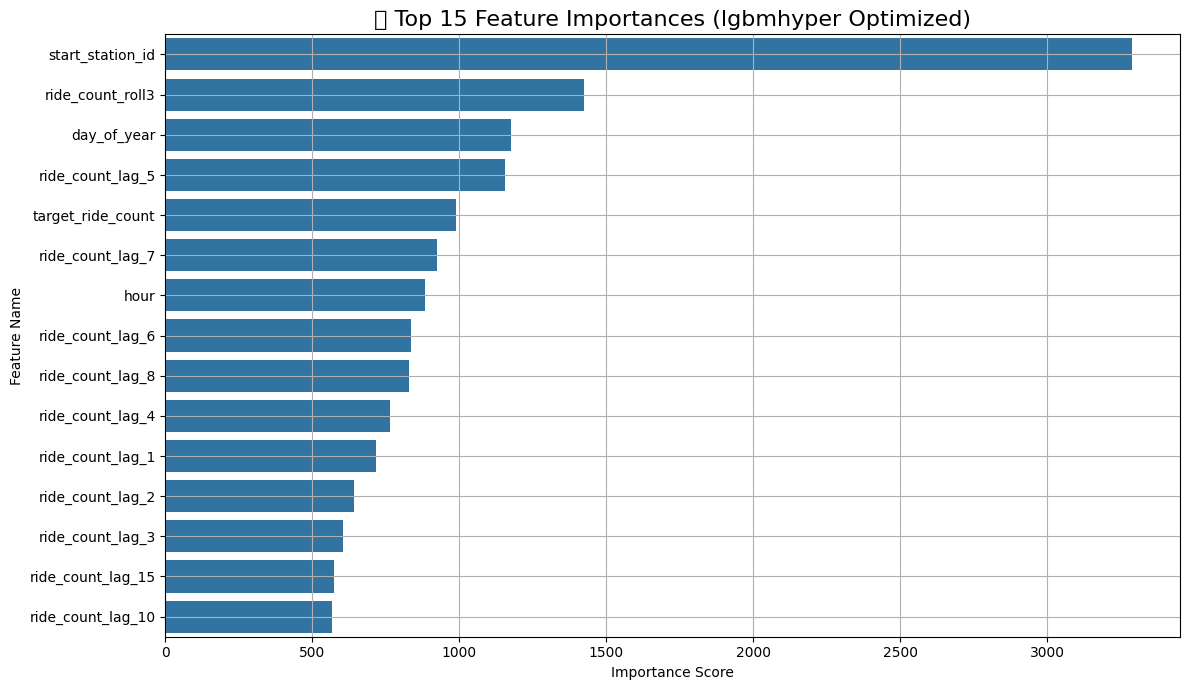

✅ Completed lgbmhyper Optimized Training!


In [2]:
# ==============================
# 📦 Imports
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import sys

from lightgbm import LGBMRegressor, early_stopping, log_evaluation  # ✅ Corrected
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.utils import split_time_series_data

# ==============================
# 📂 Load and Prepare Data
# ==============================

final_features_path = Path("C:/Users/MD/Desktop/citi/data/processed/final_features")

df_2024 = pd.read_parquet(final_features_path / "rides_citibike_final_2024_with_lags.parquet")

df = pd.concat([df_2024]).reset_index(drop=True)

print(f"✅ Combined dataset shape: {df.shape}")
print(f"✅ Columns: {df.columns.tolist()}")

# ==============================
# ✨ Manual Temporal Feature Engineering
# ==============================

df["day"] = df["hour_ts"].dt.day
df["week_of_year"] = df["hour_ts"].dt.isocalendar().week
df["quarter"] = df["hour_ts"].dt.quarter
df["is_start_of_month"] = (df["hour_ts"].dt.is_month_start).astype(int)
df["is_end_of_month"] = (df["hour_ts"].dt.is_month_end).astype(int)

print("✅ Manual temporal features added!")

# ==============================
# ✂️ Train-Test Split
# ==============================

X_train, y_train, X_test, y_test = split_time_series_data(
    df,
    cutoff_date=datetime(2025, 1, 1),
    target_column="ride_count"
)

cols_to_drop = ["hour_ts", "start_station_name", "time_of_day"]
X_train = X_train.drop(columns=cols_to_drop)
X_test = X_test.drop(columns=cols_to_drop)

print(f"✅ Final X_train shape: {X_train.shape}")
print(f"✅ Final X_test shape: {X_test.shape}")

# ==============================
# 🚀 Train Optimized LightGBM
# ==============================

lgbmhyper = LGBMRegressor(
    objective="regression",
    n_estimators=5000,         # Train longer
    learning_rate=0.02,        # Slower learning
    num_leaves=64,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training Optimized lgbmhyper model...")

lgbmhyper.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="l1",  # 'l1' = MAE
    callbacks=[
        early_stopping(stopping_rounds=100),     # ✅ Correct LightGBM callback
        log_evaluation(period=100)               # ✅ Correct LightGBM callback
    ]
)

# 🔮 Predict
y_pred_lgbm = lgbmhyper.predict(X_test)

# ==============================
# 📊 Metrics
# ==============================

mae = mean_absolute_error(y_test, y_pred_lgbm)
rmse = mean_squared_error(y_test, y_pred_lgbm) ** 0.5

print(f"✅ lgbmhyper MAE (Optimized): {mae:.2f}")
print(f"✅ lgbmhyper RMSE (Optimized): {rmse:.2f}")

# ==============================
# 📈 Feature Importances
# ==============================

feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": lgbmhyper.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df.head(15))
plt.title("🚀 Top 15 Feature Importances (lgbmhyper Optimized)", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.grid(True)
plt.tight_layout()
plt.show()

print("✅ Completed lgbmhyper Optimized Training!")


In [3]:
import mlflow
import dagshub
from dotenv import load_dotenv

# 🛠 Load environment variables
load_dotenv()

# 🛠 Initialize DagsHub MLflow connection (ONLY ONCE per session)
dagshub.init(repo_owner="duddukuntamaneesh", repo_name="citi", mlflow=True)

# 🧠 Start MLflow run to log Optimized LightGBM metrics
with mlflow.start_run(run_name="LGM_Hyper"):
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("RMSE", rmse)
    print("✅ Optimized LightGBM MAE and RMSE logged to DagsHub successfully!")


Accessing as duddukuntamaneesh

Initialized MLflow to track repo "duddukuntamaneesh/citi"

Repository duddukuntamaneesh/citi initialized!

✅ Optimized LightGBM MAE and RMSE logged to DagsHub successfully!
🏃 View run LGM_Hyper at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0/runs/13f5829154c249d1843e3057d22c1ba6
🧪 View experiment at: https://dagshub.com/duddukuntamaneesh/citi.mlflow/#/experiments/0


In [4]:
# ==========================
# 🚀 Training without PCA
# ==========================
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define the model
model_no_pca = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training LightGBM without PCA...")
model_no_pca.fit(X_train, y_train)

# Predict
y_pred_no_pca = model_no_pca.predict(X_test)

# Metrics
mae_no_pca = mean_absolute_error(y_test, y_pred_no_pca)
rmse_no_pca = mean_squared_error(y_test, y_pred_no_pca) ** 0.5

print(f"✅ No PCA - MAE: {mae_no_pca:.2f}")
print(f"✅ No PCA - RMSE: {rmse_no_pca:.2f}")


🚀 Training LightGBM without PCA...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.219804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75390
[LightGBM] [Info] Number of data points in the train set: 39333, number of used features: 688
[LightGBM] [Info] Start training from score 17.168586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning]

In [5]:
# ==========================
# 🚀 Training with PCA
# ==========================
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features before PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"✅ PCA reduced dimensions: {X_train_pca.shape[1]} components")

# Define a new model
model_with_pca = LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

print("🚀 Training LightGBM with PCA...")
model_with_pca.fit(X_train_pca, y_train)

# Predict
y_pred_with_pca = model_with_pca.predict(X_test_pca)

# Metrics
mae_with_pca = mean_absolute_error(y_test, y_pred_with_pca)
rmse_with_pca = mean_squared_error(y_test, y_pred_with_pca) ** 0.5

print(f"✅ With PCA - MAE: {mae_with_pca:.2f}")
print(f"✅ With PCA - RMSE: {rmse_with_pca:.2f}")


✅ PCA reduced dimensions: 498 components
🚀 Training LightGBM with PCA...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.136866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126990
[LightGBM] [Info] Number of data points in the train set: 39333, number of used features: 498
[LightGBM] [Info] Start training from score 17.168586
✅ With PCA - MAE: 3.95
✅ With PCA - RMSE: 5.41


c:\Users\MD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [6]:
import joblib

# Define the output path
model_save_path = r"C:\Users\MD\Desktop\citi\models\lgbmhyper.pkl"

# Save the trained LightGBM model
joblib.dump(lgbmhyper, model_save_path)

print(f"✅ LightGBM Optimized model saved to {model_save_path}")


✅ LightGBM Optimized model saved to C:\Users\MD\Desktop\citi\models\lgbmhyper.pkl


In [7]:
import joblib

# Load the model
model = joblib.load("C:\\Users\\MD\\Desktop\\citi\\models\\lgbmhyper.pkl")


# Check the type
print("✅ Model loaded successfully!")
print(f"📚 Type of loaded object: {type(model)}")


✅ Model loaded successfully!
📚 Type of loaded object: <class 'lightgbm.sklearn.LGBMRegressor'>
